# corpus processing

In [1]:
!ls ../wiki_corpus/wiki_chs

AA AB AC AD AE AF AG AH AI AJ AK AL AM


## 1. Use BFS make all corpus a list

In [2]:
import os
corpus_path = '../wiki_corpus/wiki_chs'
corpus_list = []
need_visit = [corpus_path]
while need_visit:
    path = need_visit.pop(0)
    if os.path.isdir(path):
        need_visit += [path + '/' + p for p in os.listdir(path)]
    elif '.DS_Store' not in path:
        corpus_list.append(path)

print('first 10:', corpus_list[:10])
print('\ntotal corpus:', len(corpus_list))

first 10: ['../wiki_corpus/wiki_chs/AA/wiki_00', '../wiki_corpus/wiki_chs/AA/wiki_01', '../wiki_corpus/wiki_chs/AA/wiki_02', '../wiki_corpus/wiki_chs/AA/wiki_03', '../wiki_corpus/wiki_chs/AA/wiki_04', '../wiki_corpus/wiki_chs/AA/wiki_05', '../wiki_corpus/wiki_chs/AA/wiki_06', '../wiki_corpus/wiki_chs/AA/wiki_07', '../wiki_corpus/wiki_chs/AA/wiki_08', '../wiki_corpus/wiki_chs/AA/wiki_09']

total corpus: 1230


## 2. Count n-gram for single file

In [3]:
import re
import jieba
from collections import Counter
from functools import partial, reduce

def tokenize_string(string):
    clauses = [jieba.cut(c) for c in re.findall('[\w|\d]+', string)]
    tokens = [w for c in clauses for w in list(c)]
    return tokens
    
def count_ngram(string, n):
    tokens = tokenize_string(string)
    ngrams = [tuple(tokens[i-n:i]) for i in range(len(tokens)) if i > n]
    return Counter(ngrams)


def process_file(input_file, process_func):
    with open(input_file, 'r') as f:
        return process_func(f.read())
    
## test case
input_file = corpus_list[0]
word_count = process_file(input_file, process_func=partial(count_ngram, n=2))
word_count.most_common(20)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/x8/vryxg4fn2hd0zpk8t5xd0djm0000gn/T/jieba.cache
Loading model cost 0.856 seconds.
Prefix dict has been built succesfully.


[(('的', '研究'), 174),
 (('中', '的'), 129),
 (('上', '的'), 117),
 (('不同', '的'), 109),
 (('的', '是'), 93),
 (('的', '发展'), 87),
 (('的', '理论'), 81),
 (('都', '是'), 81),
 (('也', '是'), 78),
 (('是', '一个'), 77),
 (('10', '月'), 75),
 (('之间', '的'), 74),
 (('的', '影响'), 74),
 (('研究', '的'), 73),
 (('重要', '的'), 73),
 (('则', '是'), 71),
 (('年', '的'), 70),
 (('11', '月'), 68),
 (('zh', 'wikipedia'), 66),
 (('wikipedia', 'org'), 66)]

## 3. Multicore map reduce
first allow multiprocessing process a batch of data

In [4]:
import time
import multiprocessing
def multiprocess_count_ngram(batch_file, N):
    pool = multiprocessing.Pool()
    target_func = partial(process_file, process_func=partial(count_ngram, n=N))
    ngram_counts = pool.map(target_func, batch_file)
    pool.close()
    pool.join()
    return reduce(lambda x, y : x + y, ngram_counts)

# # test case
# tic = time.time()
# word_count = multiprocess_count_ngram(corpus_list[10], 1)
# print('total time:',time.time()-tic)

cut the overall computational tasks into pieces, and aggrigate the results, which lead to the result from the whole wiki zh corpus.

In [5]:
from tqdm import tqdm

def cut_list(data, batch_size):
    return [data[x:x+batch_size] for x in range(0, len(data), batch_size)]

def wikichs_count_ngram(N, batch_size=16):
    word_count = Counter([])
    corpus_chuncks = cut_list(corpus_list, 32)

    for chunck in tqdm(corpus_chuncks):
        word_count += multiprocess_count_ngram(chunck, N)
    return word_count

word_count = wikichs_count_ngram(1)

100%|██████████| 39/39 [19:51<00:00, 26.99s/it]


In [6]:
import matplotlib.pyplot as plt
freq = [f for gram, f in word_count.most_common()]
plt.loglog(freq)
plt.grid(True)
plt.xlabel('rank of word')
plt.ylabel('word frequency')
print('total word count of corpus:', sum(freq))
print('total vocabulary count:', len(freq))

total word count of corpus: 212721993
total vocabulary count: 3714045


## 4. define stop words
first change numbers to **&lt;num>**

In [7]:
num_counter = 0
for gram in list(word_count.keys()):
    word = gram[0]
    if word.isnumeric():
        num_counter += word_count.pop(gram)
word_count['<num>'] = num_counter

remove words with frequency less than 10

In [8]:
word_count = Counter({k:v for k,v in word_count.items() if v > 10})

find stop words in top 100 popular words, and remove it from vocabulary.

In [10]:
stop_words_suspicions = [gram[0] for gram, f in word_count.most_common(100)]
print(stop_words_suspicions)

['<', '的', '年', '在', '是', 'doc', '为', '和', '月', '了', 'zh', 'id', 'org', 'https', 'wiki', 'wikipedia', 'title', 'url', 'curid', '与', '于', '有', '日', '中', '他', '被', '人', '也', '一个', '后', '并', '而', '以', '由', '上', '等', '及', '但', '将', '时', '中国', '其', '到', '对', '都', '位于', '至', '会', '或', '不', '美国', '可以', '之', '该', '成为', '日本', '则', '开始', '从', '使用', '这', '地区', '平方公里', '以及', '其中', '所', '人口', '香港', '第', '就', '台湾', '进行', '她', '包括', '个', '主要', '下', '曾', '没有', '他们', '号', '国家', '大', '米', '又', '新', '由于', '亦', '可', '前', '公司', '认为', '它', '之后', '地', '因此', '来', '获得', '其他', '当时']


In [11]:
stop_words = ['的', '在', '是', 'doc', '为', '和', '了', 'zh', 'id', 'org', 'https', 'wiki', 'wikipedia', 
              'title', 'url', 'curid', '与', '于', '中', '被', '也', '一个', '后', '并', '而', '以', '由', 
              '及', '但', '将', '时', '其', '到', '对', '位于', '至', '会', '或', '可以', '之', '该', '则', 
              '从', '这', '以及', '其中', '所', '就', '个', '曾', '又', '亦', '可', '它', '地', '来']
stop_words = set(stop_words)

In [12]:
for gram in list(word_count.keys()):
    word = gram[0]
    if word in stop_words:
        word_count.pop(gram)

After remove stop words, the vocabulary statistic is:

total word count of corpus: 159859042
total vocabulary count: 392767


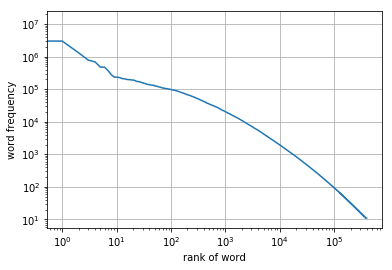

In [13]:
import matplotlib.pyplot as plt
freq = [f for gram, f in word_count.most_common()]
plt.loglog(freq)
plt.grid(True)
plt.xlabel('rank of word')
plt.ylabel('word frequency')
print('total word count of corpus:', sum(freq))
print('total vocabulary count:', len(freq))

In [17]:
def replace_nums(string):
    return '<num>' if string.isnumeric() else string
replace_nums('a')

'a'

## 5. Final version
above code are modified according to stop words and numbers. grams with frequency less than 10 has been removed. And processed counters will be saved on disk. run following command:

```python
pypy3 corpus_processing.py
```